In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
module_path = os.path.abspath("/workspace/categorical-dsm/")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [3]:
from configs import cmc_config as cfg

config = cfg.get_config()
config

data:
  anomaly_label: '1'
  categories:
  - 4
  - 4
  - 2
  - 2
  - 4
  - 4
  - 2
  - 3
  dataset: cmc
  label_column: class_numberofchildren
  numerical_features: 0
device: !!python/object/apply:torch.device
- cpu
devtest: false
eval:
  batch_size: 1024
model:
  act: gelu
  dropout: 0.0
  ema_rate: 0.999
  embedding_type: fourier
  estimate_noise: true
  layers: 20
  name: tab-resnet
  ndims: 1024
  num_scales: 20
  sigma_max: 1.0
  sigma_min: 0.1
  tau_max: 20
  tau_min: 2.0
  time_embedding_size: 128
msma:
  checkpoint: best
  denoise: true
optim:
  beta1: 0.9
  beta2: 0.999
  grad_clip: 1.0
  lr: 0.0003
  optimizer: AdamW
  scheduler: none
  weight_decay: 0.0001
seed: 42
sweep:
  early_terminate:
    eta: 2
    min_iter: 50000
    s: 3
    type: hyperband
  method: bayes
  metric:
    name: val_loss
  parameters:
    model_act:
      values:
      - gelu
      - swish
    model_dropout:
      values:
      - 0.0
      - 0.1
      - 0.2
      - 0.3
      - 0.4
      - 0.5
    model

In [4]:
sum(config.data.categories)

25

In [5]:
assert config.data.dataset == "cmc"

In [6]:
workdir = f"/workspace/categorical-dsm/results/{config.data.dataset}/"
workdir

'/workspace/categorical-dsm/results/cmc/'

In [32]:
from ood_detection_helper import ood_metrics, auxiliary_model_analysis


def get_msma_results(workdir, ckpt_num=-1, seed=0):
    #TODO: USE PYOD MODELS!
    np.random.seed(42)
    workdir = os.path.join(workdir, f"seed_{seed}")
    denoise = config.msma.denoise
    ckpt_dir = os.path.join(workdir, "checkpoints")
    ckpts = sorted(os.listdir(ckpt_dir))
    ckpt = ckpts[ckpt_num]
    step = ckpt.split("-")[0]
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["train"]["score_norms"]
    np.random.shuffle(X_train)
    X_val = outdict["val"]["score_norms"]
    X_train = np.concatenate((X_train, X_val))
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(5,6,1),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

In [8]:
# Load baseline results 
baseline_metrics = pd.read_csv(f"results/{config.data.dataset}_baseline_metrics.csv", index_col=0)
baseline_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                        \
          count       mean       std        min        25%        50%   
model                                                                   
DAGMM       5.0  61.355364  4.924090  55.723180  58.908046  60.177203   
DSVDD       5.0  52.169540  5.231310  47.306034  48.120211  49.796456   
ECOD        5.0  52.969349  3.518852  47.892720  52.298851  52.634100   
IForest     5.0  54.803640  2.410960  52.729885  52.825670  54.262452   

                                 ap                                  \
               75%        max count       mean       std        min   
model                                                                 
DAGMM    63.242337  68.726054   5.0  24.986448  5.747865  19.112223   
DSVDD    57.590996  58.034004   5.0  21.989043  6.148147  16.516379   
ECOD     54.477969  57.543103   5.0  23.785540  1.753486  21.748175   
IForest  55.651341  58.548851   5.0  22.721694  1.569435  21.540930   

                                                     
               25%        50%        75%        max  
model                                                
DAGMM    22.389375  23.226134  25.891619  34.312887  
DSVDD    18.830034  20.617284  21.543125  32.438392  
ECOD     22.934426  23.293737  24.618773  26.332589  
IForest  21.908709  22.195088  22.508114  25.455633

========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 8.503924 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
8.503924 (0.944978) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


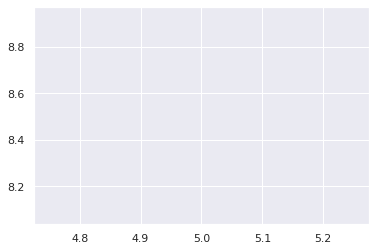

---Likelihoods---
Training: 20.975
Inlier: 19.599
Outlier: 20.858
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 14.555230 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
14.555230 (2.248063) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


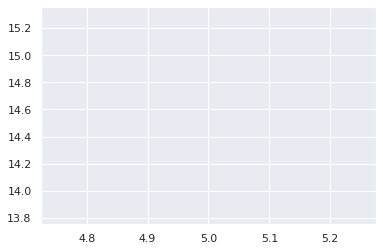

---Likelihoods---
Training: 27.247
Inlier: 27.985
Outlier: 22.892
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 10.299254 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
10.299254 (0.473620) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


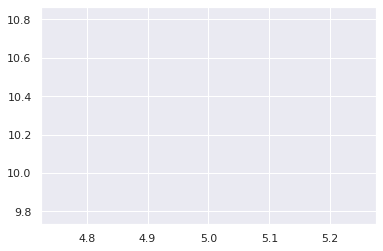

---Likelihoods---
Training: 21.645
Inlier: 20.332
Outlier: 20.093
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 10.270312 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
10.270312 (1.495864) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


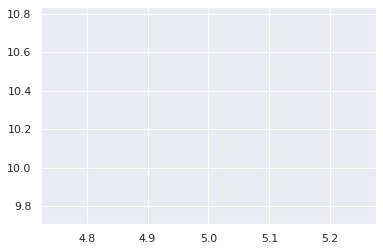

---Likelihoods---
Training: 21.089
Inlier: 19.882
Outlier: 20.458
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best: 8.665714 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
---------------------------------------------------------------------------
8.665714 (1.413561) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}


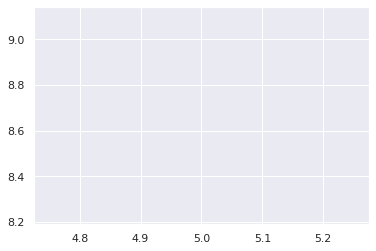

---Likelihoods---
Training: 20.561
Inlier: 19.014
Outlier: 18.178
========================= Training KD Tree =========================


In [33]:
all_metrics = []
for i in range(5):
    msma_results = get_msma_results(workdir, seed=i)
    all_metrics.append(msma_results)

In [34]:
num_anos = len(all_metrics[0]["GMM"]["ood_scores"].ravel())
num_inliers = len(all_metrics[0]["GMM"]["test_scores"].ravel())
ano_ratio = num_anos / (num_anos+num_inliers)
print(f"Anomaly ratio for test set of {config.data.dataset}: {num_anos}/{num_inliers+num_anos} = {ano_ratio:.2f}")

Anomaly ratio for test set of cmc: 29/173 = 0.17


In [35]:
gmm_metrics  = pd.concat(m["GMM"]["metrics"].reset_index(drop=True) for m in all_metrics
                        ).reset_index(drop=True)
gmm_metrics['seed'] = np.arange(5)
gmm_metrics['model'] = "MSMA-GMM"
gmm_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,24.821942,41.913314,65.277778,65.277778,23.453320,84.884108,54.525862,2.000000
std,8.475583,5.090056,13.617133,13.617133,8.695187,2.194388,7.537057,1.581139
min,18.503045,33.249521,42.361111,42.361111,16.788166,83.170071,47.701149,0.000000
25%,18.548619,41.463123,65.277778,65.277778,17.171615,83.891772,50.862069,1.000000
50%,22.201272,44.528257,68.750000,68.750000,21.308250,84.139566,51.772031,2.000000
75%,25.890993,44.707854,72.222222,72.222222,23.926220,84.508383,55.148467,3.000000
max,38.965781,45.617816,77.777778,77.777778,38.072350,88.710749,67.145594,4.000000


In [11]:
kd_metrics  = pd.concat(m["KD"]["metrics"].reset_index(drop=True) for m in all_metrics
                       ).reset_index(drop=True)
kd_metrics['seed'] = np.arange(5)
kd_metrics['model'] = "MSMA-KD"
kd_metrics

kd_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,25.865997,38.000479,67.638889,67.638889,24.950099,86.034788,57.883142,2.000000
std,9.747231,3.772069,7.058098,7.058098,9.962794,1.135150,4.965692,1.581139
min,19.979550,32.112069,59.722222,59.722222,19.005467,84.805028,53.927203,0.000000
25%,21.674235,36.314655,60.416667,60.416667,20.615404,85.299732,55.340038,1.000000
50%,21.938889,40.158046,71.527778,71.527778,20.871776,85.784206,56.681034,2.000000
75%,22.516931,40.517241,71.527778,71.527778,21.564902,86.601718,56.968391,3.000000
max,43.220378,40.900383,75.000000,75.000000,42.692944,87.683256,66.499042,4.000000


In [12]:
df_metrics = pd.concat([gmm_metrics, kd_metrics, baseline_metrics])
df_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                        \
           count       mean       std        min        25%        50%   
model                                                                    
DAGMM        5.0  61.355364  4.924090  55.723180  58.908046  60.177203   
DSVDD        5.0  52.169540  5.231310  47.306034  48.120211  49.796456   
ECOD         5.0  52.969349  3.518852  47.892720  52.298851  52.634100   
IForest      5.0  54.803640  2.410960  52.729885  52.825670  54.262452   
MSMA-GMM     5.0  54.885057  7.925739  46.527778  52.514368  53.520115   
MSMA-KD      5.0  57.883142  4.965692  53.927203  55.340038  56.681034   

                                  ap                                  \
                75%        max count       mean       std        min   
model                                                                  
DAGMM     63.242337  68.726054   5.0  24.986448  5.747865  19.112223   
DSVDD     57.590996  58.034004   5.0  21.989043  6.148147  16.516379   
ECOD      54.477969  57.543103   5.0  23.785540  1.753486  21.748175   
IForest   55.651341  58.548851   5.0  22.721694  1.569435  21.540930   
MSMA-GMM  53.831418  68.031609   5.0  25.866631  9.929354  19.378176   
MSMA-KD   56.968391  66.499042   5.0  25.865997  9.747231  19.979550   

                                                      
                25%        50%        75%        max  
model                                                 
DAGMM     22.389375  23.226134  25.891619  34.312887  
DSVDD     18.830034  20.617284  21.543125  32.438392  
ECOD      22.934426  23.293737  24.618773  26.332589  
IForest   21.908709  22.195088  22.508114  25.455633  
MSMA-GMM  19.412322  20.886268  26.916593  42.739795  
MSMA-KD   21.674235  21.938889  22.516931  43.220378

In [13]:
# df_metrics.to_csv(f"results/{config.data.dataset}_final_metrics.csv")

In [31]:
df_stats = df_metrics.groupby('model').describe()

for metric in ["ap", "roc_auc"]:
    latex_str = [metric]
    latex_str.append(f"{ano_ratio:.2f}")
    df = df_stats.loc[["IForest","ECOD","DAGMM","DSVDD","MSMA-GMM"], metric]
    best =  df["mean"].max()
    for m in df[["mean", "std"]].values:
        _str = f"{m[0]:.2f} \pm~{m[1]:.2f}" 
        if np.isclose(m[0], best):
            _str = "\B "+_str
        latex_str.append(_str)
    latex_str = " & ".join(latex_str)
    print(latex_str)

ap & 0.17 & 22.72 \pm~1.57 & 23.79 \pm~1.75 & 24.99 \pm~5.75 & 21.99 \pm~6.15 & \B 25.87 \pm~9.93
roc_auc & 0.17 & 54.80 \pm~2.41 & 52.97 \pm~3.52 & \B 61.36 \pm~4.92 & 52.17 \pm~5.23 & 54.89 \pm~7.93


In [15]:
df_melt = df_metrics.drop(columns="seed").melt(id_vars="model", var_name="metric")
df_melt

,model,metric,value
0,MSMA-GMM,ap,19.378176
1,MSMA-GMM,ap,42.739795
2,MSMA-GMM,ap,20.886268
3,MSMA-GMM,ap,19.412322
4,MSMA-GMM,ap,26.916593
...,...,...,...
205,DSVDD,roc_auc,48.120211
206,DSVDD,roc_auc,57.590996
207,DSVDD,roc_auc,47.306034
208,DSVDD,roc_auc,58.034004


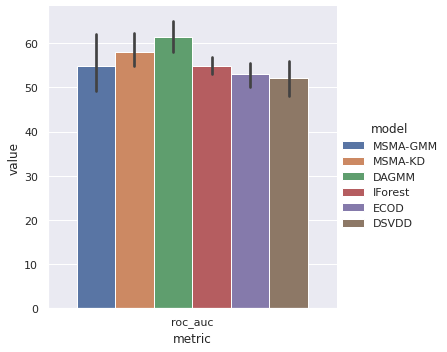

In [16]:
sns.catplot(data=df_melt.query("metric=='roc_auc'"), x="metric", y="value", hue="model", kind="bar")

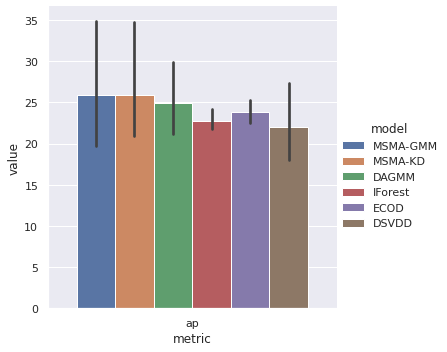

In [17]:
sns.catplot(data=df_melt.query("metric=='ap'"), x="metric", y="value", hue="model", kind="bar")